In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#### 1. 生成模拟数据集。

In [2]:
dataset_size = 200
data = []
label = []
np.random.seed(0)

# 以原点为圆心，半径为1的圆把散点划分成红蓝两部分，并加入随机噪音。
for i in range(dataset_size):
    x1 = np.random.uniform(-1,1)
    x2 = np.random.uniform(0,2)
    if x1**2 + x2**2 <= 1:
        data.append([np.random.normal(x1, 0.1),np.random.normal(x2,0.1)])
        label.append(0)
    else:
        data.append([np.random.normal(x1, 0.1), np.random.normal(x2, 0.1)])
        label.append(1)
        
data = np.hstack(data).reshape(-1,2)
label = np.hstack(label).reshape(-1, 1)

In [3]:
print(type(data))
print(data.shape)

<class 'numpy.ndarray'>
(200, 2)


In [4]:
type(label)
print(label.shape)

(200, 1)


In [5]:
data[0:5]

array([[ 0.19550081,  1.65446805],
       [-0.05768156,  1.27665251],
       [ 0.94172988,  0.91231039],
       [ 0.18047545,  1.88456071],
       [ 1.10664459,  1.5778013 ]])

In [6]:
label[0:5]

array([[1],
       [1],
       [1],
       [1],
       [1]])

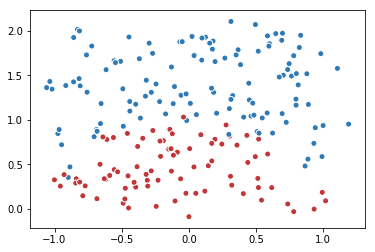

In [8]:

plt.scatter(data[:,0], data[:,1], c=label[:,0], cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white")
plt.show()

#### 2. 定义一个获取权重，并自动加入正则项到损失的函数。一般tf.Variable都是需要训练的权重参数

- tf.contrib.layers.l1_regularizer(scale, scope=None)
- tf.contrib.layers.l2_regularizer(scale, scope=None)

In [9]:
def get_weight(shape, var_lambda):
    w = tf.Variable(tf.random_normal(shape), dtype=tf.float32)
    # add_to_collection()函数将新生成变量的L2正则化损失加入集合losses
    tf.add_to_collection('losses', tf.contrib.layers.l2_regularizer(var_lambda)(w))
    return w

#### 3. 定义神经网络。

In [10]:
x = tf.placeholder(tf.float32, shape=(None, 2))
y_ = tf.placeholder(tf.float32, shape=(None, 1))

# 每层节点的个数
layer_dimension = [2,10,5,3,1]

n_layers = len(layer_dimension)

cur_layer = x
in_dimension = layer_dimension[0]

# 循环生成网络结构，输入层X[None, 2]，隐藏层W1[2, 10]、W2[10, 5]、W3[5, 3]，输出层Y[None, 1]
for i in range(1, n_layers):
    out_dimension = layer_dimension[i]
    weight = get_weight([in_dimension, out_dimension], 0.003)
    bias = tf.Variable(tf.constant(0.1, shape=[out_dimension]))
    cur_layer = tf.nn.elu(tf.matmul(cur_layer, weight) + bias)
    in_dimension = layer_dimension[i]

y= cur_layer

# 损失函数的定义。
mse_loss = tf.reduce_sum(tf.pow(y_ - y, 2)) / dataset_size
tf.add_to_collection('losses', mse_loss) # 向当前计算图中添加张量集合
loss = tf.add_n(tf.get_collection('losses')) #返回当前计算图中手动添加的张量集合

#### 4. 训练不带正则项的损失函数mse_loss。

After 999 steps, mse_loss: 0.054491
After 1999 steps, mse_loss: 0.032417
After 2999 steps, mse_loss: 0.025494
After 3999 steps, mse_loss: 0.023485
After 4999 steps, mse_loss: 0.019531
After 5999 steps, mse_loss: 0.017027
After 6999 steps, mse_loss: 0.015801
After 7999 steps, mse_loss: 0.015011
After 8999 steps, mse_loss: 0.013874
After 9999 steps, mse_loss: 0.012855


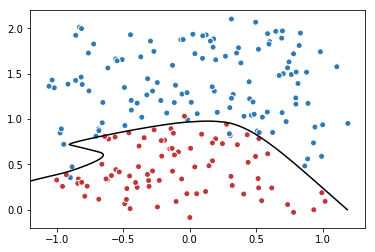

In [11]:
# 定义训练的目标函数mse_loss，训练次数及训练模型
train_op = tf.train.AdamOptimizer(0.001).minimize(mse_loss)
TRAINING_STEPS = 10000

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for i in range(TRAINING_STEPS):
        sess.run(train_op, feed_dict={x: data, y_: label})
        if i % 1000 == 1000 - 1:
            print("After %d steps, mse_loss: %f" % (i,sess.run(mse_loss, feed_dict={x: data, y_: label})))

    # 画出训练后的分割曲线       
    xx, yy = np.mgrid[-1.2:1.2:.01, -0.2:2.2:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = sess.run(y, feed_dict={x:grid})
    probs = probs.reshape(xx.shape)

plt.scatter(data[:,0], data[:,1], c=label[:,0],
           cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white")
plt.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.1)
plt.show()

#### 5. 训练带正则项的损失函数loss。

After 999 steps, loss: 0.202945
After 1999 steps, loss: 0.171391
After 2999 steps, loss: 0.142243
After 3999 steps, loss: 0.121523
After 4999 steps, loss: 0.105033
After 5999 steps, loss: 0.091263
After 6999 steps, loss: 0.079575
After 7999 steps, loss: 0.070653
After 8999 steps, loss: 0.063851
After 9999 steps, loss: 0.059155


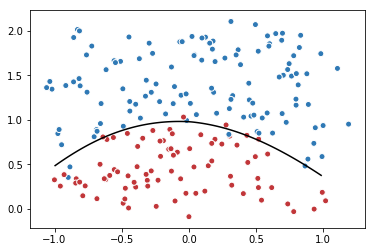

In [12]:
# 定义训练的目标函数loss，训练次数及训练模型
train_op = tf.train.AdamOptimizer(0.001).minimize(loss)
TRAINING_STEPS = 10000

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for i in range(TRAINING_STEPS):
        sess.run(train_op, feed_dict={x: data, y_: label})
        if i % 1000 == 1000 - 1:
            print("After %d steps, loss: %f" % (i,sess.run(loss, feed_dict={x: data, y_: label})))

    # 画出训练后的分割曲线       
    xx, yy = np.mgrid[-1:1:.01, 0:2:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = sess.run(y, feed_dict={x:grid})
    probs = probs.reshape(xx.shape)

plt.scatter(data[:,0], data[:,1], c=label[:,0],
           cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white")
plt.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.1)
plt.show()

In [95]:
# https://blog.csdn.net/lilong117194/article/details/79130032